# **Installing Libraries**

- torch
- scikit-learn
- pandas
- numpy
- ucimlrepo
- matplotlib
- captum


In [120]:
pip install torch scikit-learn pandas numpy ucimlrepo matplotlib captum

# **Import Libraries**


In [121]:
# Import necessary libraries
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from captum.attr import Lime
from captum.attr import visualization as viz
import numpy as np
import pandas as pd
import random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

### Feedforward Neural Network: `LinearNN`

#### **Key Parameters**
- **`input_size`**: The number of input features.
- **`hidden_size`**: The number of neurons in the hidden layer.
- **`output_size`**: The number of output classes or features.

#### **Network Structure**
1. **Fully Connected Layer**: Connects the input features to the hidden layer (`input_size -> hidden_size`).
2. **ReLU Activation**: Applies the Rectified Linear Unit activation function to introduce non-linearity.
3. **Dropout Layer**: Regularizes the network with a dropout rate of 30% (`p=0.3`) to reduce overfitting.
4. **Fully Connected Layer**: Maps the hidden layer to the output layer (`hidden_size -> output_size`).

#### **Forward Pass**
- Takes an input tensor of shape `(batch_size, input_size)`.
- Propagates it through the network layers.
- Outputs a tensor of shape `(batch_size, output_size)`.


In [136]:
class LinearNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_size, hidden_size),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),
            # nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

### Load and Preprocess the Breast Cancer Dataset: `load_breast_cancer_data`

This function fetches the **Breast Cancer Wisconsin Diagnostic Dataset** and splits it into training, validation, and test sets for machine learning tasks.

#### **Key Parameters**
- **`val_size`**: Proportion of the training set used for validation. *(Default: 0.1)*
- **`random_state`**: Seed for reproducibility during dataset splitting. *(Default: 42)*

#### **Process**
1. **Dataset Fetching**:  
   Retrieves the dataset from the **UCI Machine Learning Repository** (Dataset ID: `17`).
   
2. **Feature Extraction**:  
   - **Features (X)**: Predictor variables from the dataset.
   - **Target (y)**: Labels for classification.

3. **Dataset Splitting**:
   - **Train-Test Split**: 80% training, 20% test.
   - **Train-Validation Split**: Further splits the training set into training and validation subsets based on `val_size`.

#### **Returns**
A dictionary containing:
- **`X_train`**: Training feature set.
- **`X_val`**: Validation feature set.
- **`X_test`**: Test feature set.
- **`y_train`**: Training labels.
- **`y_val`**: Validation labels.
- **`y_test`**: Test labels.

This function ensures proper stratification to maintain class balance in all splits.


In [137]:
def load_breast_cancer_data(val_size=0.1, random_state=42):
    dataset = load_breast_cancer()
    X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
    y = pd.Series(dataset.target)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, random_state=random_state
    )

    return {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
    }

data_splits = load_breast_cancer_data()

### Plot Training and Validation Metrics: `plot_metrics`

This function visualizes the progression of training and validation accuracy, as well as validation F1-scores, over multiple epochs during model training.

#### **Inputs**
- **`epochs`**: A list of epoch numbers.
- **`train_accuracies`**: Training accuracy values recorded at each epoch.
- **`val_accuracies`**: Validation accuracy values recorded at each epoch.
- **`val_f1_scores`**: Validation F1-score values recorded at each epoch.

#### **Visualization**
1. **Accuracy Plot**:
   - Compares training and validation accuracy across epochs.
   - Includes markers (`o` for training, `x` for validation) for easy differentiation.

2. **F1-Score Plot**:
   - Displays validation F1-scores for each epoch.
   - Uses a distinct marker (`s`) and color (`orange`) for clear visibility.

#### **Features**
- Plots are presented side-by-side for quick comparison.
- Includes gridlines and legends for better interpretability.
- Automatically adjusts layout for a clean display.

#### **Purpose**
- Helps in assessing the model's performance trends during training.
- Provides insights into overfitting or underfitting by comparing training and validation metrics.

This function ensures a clear visualization of model training progress and evaluation.


In [138]:
def plot_metrics(epochs, train_accuracies, val_accuracies, val_f1_scores):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="x")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1-Score", color="orange", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.title("F1-Score over Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Plot ROC Curve: `plot_roc_curve`

This function generates a Receiver Operating Characteristic (ROC) curve and calculates the Area Under the Curve (AUC), providing a graphical representation of the model's performance in binary classification tasks.

#### **Inputs**
- **`y_true`**: True binary labels for the test dataset.
- **`y_probs`**: Predicted probabilities for the positive class.
- **`title`**: Customizable title for the ROC curve plot. *(Default: "ROC Curve")*

#### **ROC Curve Overview**
- The ROC curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold levels.
- The closer the curve is to the top-left corner, the better the model's performance.
- The **AUC (Area Under the Curve)** quantifies the overall ability of the model to distinguish between the classes:
  - AUC = 1: Perfect classifier.
  - AUC = 0.5: No discriminatory ability (random guessing).

#### **Visualization**
1. **ROC Curve**:
   - Solid line: Plots the TPR against the FPR.
   - Dashed diagonal line: Represents a random classifier (baseline).

2. **AUC Display**:
   - The legend includes the computed AUC value for quick interpretation.

#### **Purpose**
- Provides an intuitive and quantitative measure of model performance.
- Highlights the trade-off between sensitivity (TPR) and specificity (1 - FPR).

This plot is essential for evaluating binary classification models and comparing their discriminative capabilities.


In [139]:
def plot_roc_curve(y_true, y_probs, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Step 1: Load and Preprocess the Dataset

This step involves loading the Breast Cancer Wisconsin Diagnostic dataset, preprocessing the features and labels, and preparing the data for training, validation, and testing.

#### **Process Overview**
- **Load Dataset**:
   - Fetches the dataset using `load_breast_cancer_data`.

- **Ensure Numeric Features**:
   - Filters numeric columns from the feature data.
   - Fills missing values with `0` to ensure compatibility with the model.

- **Ensure Numeric Labels**:
   - Converts categorical labels into numeric form using `pd.factorize`.

- **Standardize Features**:
   - Standardizes feature data to zero mean and unit variance using `StandardScaler`:

- **Convert to PyTorch Tensors**:
   - Converts both features and labels into PyTorch tensors to facilitate training with PyTorch.

In [140]:
scaler = StandardScaler()
X_train = scaler.fit_transform(data_splits["X_train"])
X_val = scaler.transform(data_splits["X_val"])
X_test = scaler.transform(data_splits["X_test"])

y_train = data_splits["y_train"].values
y_val = data_splits["y_val"].values
y_test = data_splits["y_test"].values

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

### Training the Model: `train_model`

This function trains and evaluates a feedforward neural network on the Breast Cancer dataset. It tracks metrics and provides visual insights into the training process.

#### **Steps:**
- **Model Initialization**:
  - Defines the network structure with input size, hidden size, and output size.
  - Uses CrossEntropyLoss for classification and Adam optimizer for weight updates.

- **Training Loop**:
  - Runs for a specified number of epochs.
  - Computes training loss, performs backpropagation, and updates weights.
  - Tracks metrics: training accuracy, validation accuracy, and validation F1-score.

- **Validation**:
  - Evaluates the model on the validation set during training to monitor generalization.
  - Logs metrics at regular intervals.

- **Metric Visualization**:
  - Plots accuracy and F1-score over epochs for training and validation.

- **Test Evaluation**:
  - Computes final test accuracy and F1-score on unseen data.
  - Plots the ROC curve and calculates the AUC to assess model discrimination.

This function integrates training, validation, and testing while offering detailed performance insights.


Epoch 10/50, Loss: 2.5355, Train Acc: 0.0929, Val Acc: 0.1304, Val F1: 0.2161
Epoch 20/50, Loss: 2.3361, Train Acc: 0.4817, Val Acc: 0.6087, Val F1: 0.7012
Epoch 30/50, Loss: 1.8701, Train Acc: 0.7262, Val Acc: 0.7391, Val F1: 0.7901
Epoch 40/50, Loss: 1.5662, Train Acc: 0.8386, Val Acc: 0.8478, Val F1: 0.8508
Epoch 50/50, Loss: 1.4366, Train Acc: 0.9144, Val Acc: 0.8696, Val F1: 0.8651
Final Test Accuracy: 0.9211
Final Test F1-Score: 0.9249


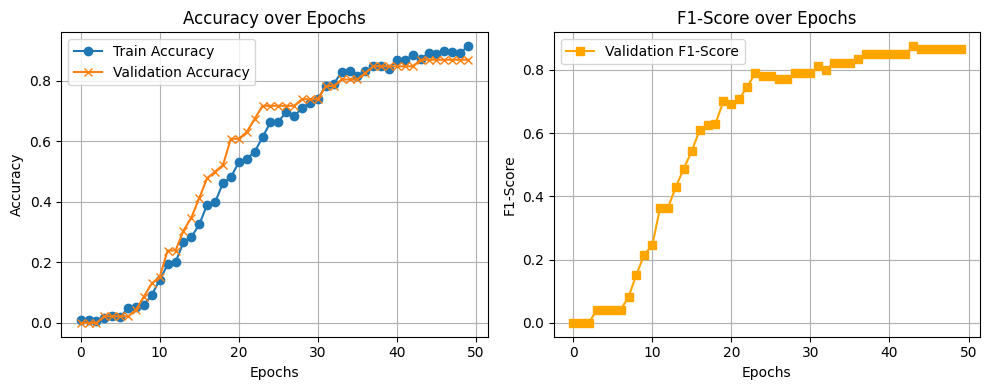

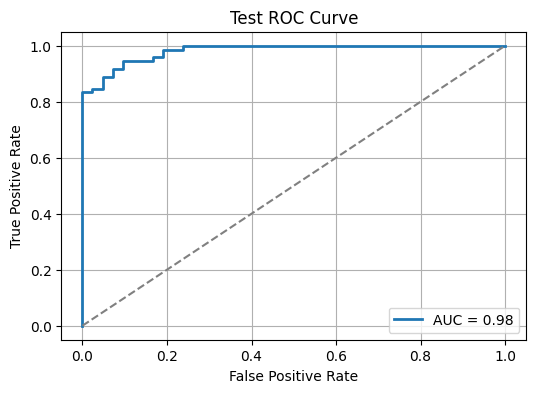

In [141]:
def train_model(num_epochs=50, learning_rate=0.0001, hidden_size=16, patience=5):
    input_size = X_train.shape[1]
    output_size = len(torch.unique(y_train))
    model = LinearNN(input_size, hidden_size, output_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    train_accuracies = []
    val_accuracies = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
            train_total += batch_y.size(0)

        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                val_loss += criterion(outputs, batch_y).item()
                val_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
                val_total += batch_y.size(0)
                all_val_preds.append(outputs)
                all_val_labels.append(batch_y)

        val_accuracy = val_correct / val_total
        val_accuracies.append(val_accuracy)
        all_val_preds = torch.cat(all_val_preds)
        all_val_labels = torch.cat(all_val_labels)
        val_f1 = f1_score(all_val_labels.numpy(), all_val_preds.argmax(dim=1).numpy(), average="weighted")
        val_f1_scores.append(val_f1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

    model.load_state_dict(best_model_state)

    # Evaluate on test set
    model.eval()
    test_correct = 0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            test_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
            all_test_preds.append(outputs)
            all_test_labels.append(batch_y)

    all_test_preds = torch.cat(all_test_preds)
    all_test_labels = torch.cat(all_test_labels)
    test_accuracy = test_correct / len(y_test)
    test_f1 = f1_score(all_test_labels.numpy(), all_test_preds.argmax(dim=1).numpy(), average="weighted")
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Test F1-Score: {test_f1:.4f}")

    plot_metrics(range(len(train_accuracies)), train_accuracies, val_accuracies, val_f1_scores)

    plot_roc_curve(all_test_labels.numpy(), torch.softmax(all_test_preds, dim=1).numpy(), title="Test ROC Curve")

    return model, all_test_preds, all_test_labels

model, test_preds, test_labels = train_model()

In [128]:
lime = Lime(model)

### Selecting Samples for LIME Explanations: `select_samples`

This function identifies specific samples from the test set for explanation generation using LIME.

#### **Purpose**:
- Selects one sample each for:
  - **True Positive (TP)**
  - **True Negative (TN)**
  - **False Positive (FP)**
  - **False Negative (FN)**

#### **Inputs**:
- **`X_test`**: Test feature data.
- **`y_test`**: True labels.
- **`predictions`**: Model's predicted labels.

#### **Outputs**:
- A list of indices corresponding to the selected TP, FP, TN, and FN samples.

This function ensures a diverse set of samples for meaningful explanation generation.


In [129]:
def select_samples(X_test, y_test, predictions):
    tp_idx = np.where((y_test == 1) & (predictions == 1))[0]
    tn_idx = np.where((y_test == 0) & (predictions == 0))[0]
    fp_idx = np.where((y_test == 0) & (predictions == 1))[0]
    fn_idx = np.where((y_test == 1) & (predictions == 0))[0]

    selected_indices = []
    if len(tp_idx) > 0:
        selected_indices.append(tp_idx[0])
    if len(tn_idx) > 0:
        selected_indices.append(tn_idx[0])
    if len(fp_idx) > 0:
        selected_indices.append(fp_idx[0])
    if len(fn_idx) > 0:
        selected_indices.append(fn_idx[0])

    return selected_indices

### Generating LIME Explanations: `generate_lime_explanations`

This function creates LIME-based feature importance explanations for selected test samples.

#### **Purpose**:
- Highlights the contribution of individual features to the model's predictions for specific samples.

#### **Inputs**:
- **`model`**: Trained PyTorch model.
- **`X_test`**: Test feature data.
- **`selected_indices`**: Indices of samples to explain.
- **`feature_names`**: Names of the features for visualization.

#### **Output**:
- Horizontal bar charts visualizing feature importance for each selected sample.

This function provides intuitive insights into the model's decision-making process.


In [130]:
def generate_lime_explanations(model, X_test, selected_indices, feature_names):
    lime = Lime(model)

    for idx in selected_indices:
        input_sample = X_test[idx].unsqueeze(0)
        explanation = lime.attribute(input_sample, target=1, n_samples=50)
        explanation = explanation.squeeze().detach().numpy()

        plt.figure(figsize=(6, 6))
        plt.barh(feature_names, explanation, color="skyblue")
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.title(f"LIME Explanation for Sample {idx}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

### Evaluating LIME Explanations: `evaluate_explanations`

This function generates and evaluates LIME explanations for selected test samples, providing metrics to assess explanation quality.

#### **Purpose**:
- Quantifies explanation quality using metrics such as:
  - **Time**: Time taken to generate the explanation.
  - **Parsimony**: Number of features with scaled importance above a threshold (`tau`).
  - **Correctness**: Impact of perturbing top important features on model predictions.

#### **Inputs**:
- **`model`**: Trained PyTorch model.
- **`X_test`**: Test feature data.
- **`selected_indices`**: Indices of test samples for explanation.
- **`feature_names`**: Names of features for visualization.
- **`tau`**: Threshold for parsimony evaluation. *(Default: 0.1)*

#### **Outputs**:
- **Metrics**: A list of dictionaries containing `Time`, `Parsimony`, and `Correctness` for each sample.
- **Visualizations**: Horizontal bar charts of scaled feature importance for each sample.

This function evaluates the efficiency, simplicity, and reliability of LIME explanations for model predictions.


In [131]:
def evaluate_explanations(model, X_test, selected_indices, feature_names, tau=0.1):
    lime = Lime(model)
    metrics = []

    for idx in selected_indices:
        input_sample = X_test[idx].unsqueeze(0)  # Ensure sample is on the correct device

        # Measure time for explanation generation
        start_time = time.time()
        explanation = lime.attribute(input_sample, target=1, n_samples=50)
        elapsed_time = time.time() - start_time

        # Normalize explanation values to [-1, 1]
        explanation = explanation.squeeze().detach().cpu().numpy()
        explanation_scaled = explanation / np.max(np.abs(explanation))

        # Parsimony metric: Count features exceeding threshold
        num_features_above_threshold = np.sum(np.abs(explanation_scaled) > tau)

        # Correctness metric: Evaluate effect of perturbing top features
        top_features_idx = np.argsort(-np.abs(explanation_scaled))[:num_features_above_threshold]
        perturbed_sample = input_sample.clone()
        perturbed_sample[0, top_features_idx] = 0  # Set top features to zero

        with torch.no_grad():
            original_output = model(input_sample).squeeze()
            perturbed_output = model(perturbed_sample).squeeze()

            # Handle logits or single output for binary/multiclass
            if len(original_output.shape) > 0:
                original_output = torch.softmax(original_output, dim=0).cpu().numpy()
                perturbed_output = torch.softmax(perturbed_output, dim=0).cpu().numpy()
            else:
                original_output = torch.sigmoid(original_output).cpu().numpy()
                perturbed_output = torch.sigmoid(perturbed_output).cpu().numpy()

            correctness = np.abs(original_output - perturbed_output).sum()

        # Append metrics for this sample
        metrics.append({
            "Sample Index": idx,
            "Time (s)": elapsed_time,
            "Parsimony": num_features_above_threshold,
            "Correctness": correctness,
        })

        # Visualize explanation
        plt.figure(figsize=(12, 6))
        plt.barh(feature_names, explanation_scaled, color="skyblue")
        plt.xlabel("Scaled Feature Importance")
        plt.ylabel("Features")
        plt.title(f"LIME Explanation for Sample {idx}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # Print explanation metrics
        print(f"Sample {idx} - Time: {elapsed_time:.4f}s, "
              f"Parsimony: {num_features_above_threshold}, "
              f"Correctness: {correctness:.4f}")

    return metrics


Explanation Evaluation Metrics:


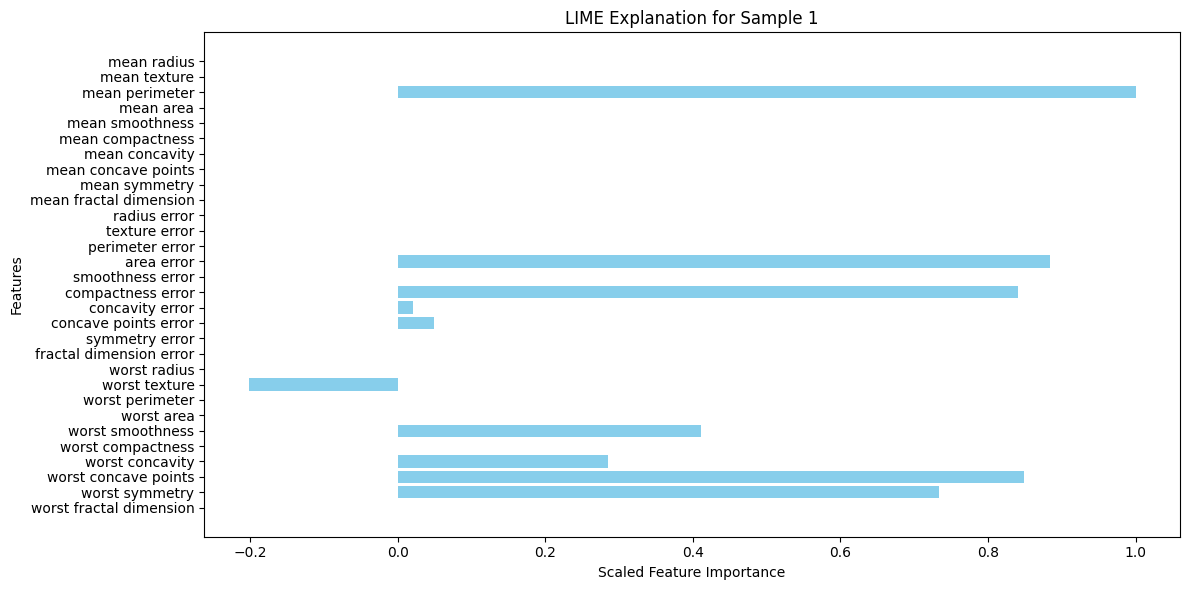

Sample 1 - Time: 0.0339s, Parsimony: 8, Correctness: 0.2337


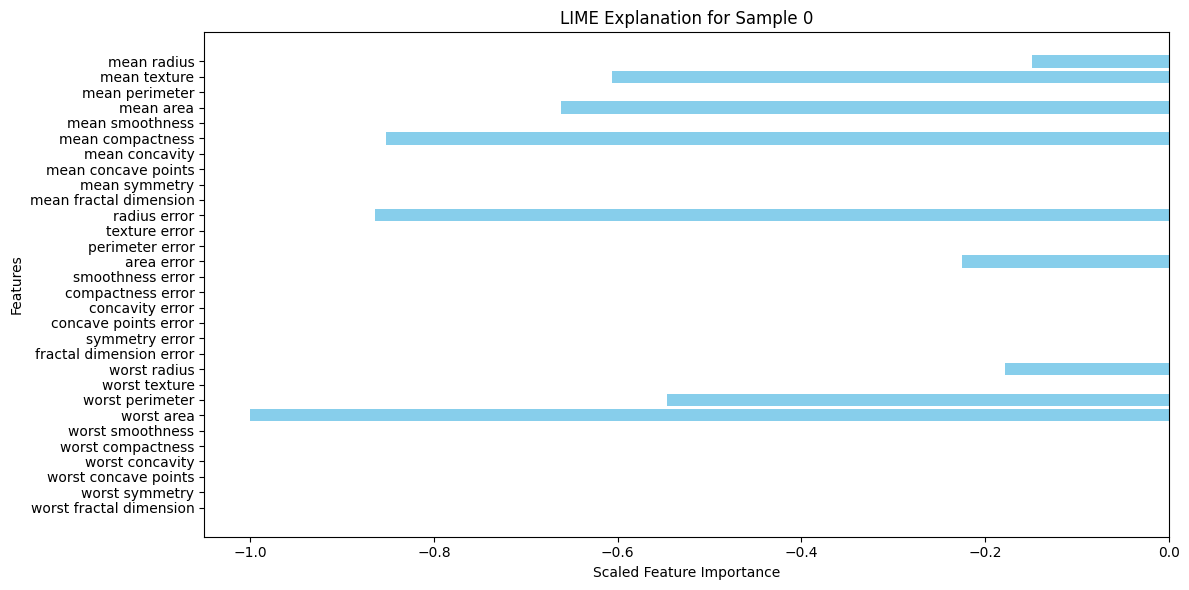

Sample 0 - Time: 0.0413s, Parsimony: 9, Correctness: 0.6669


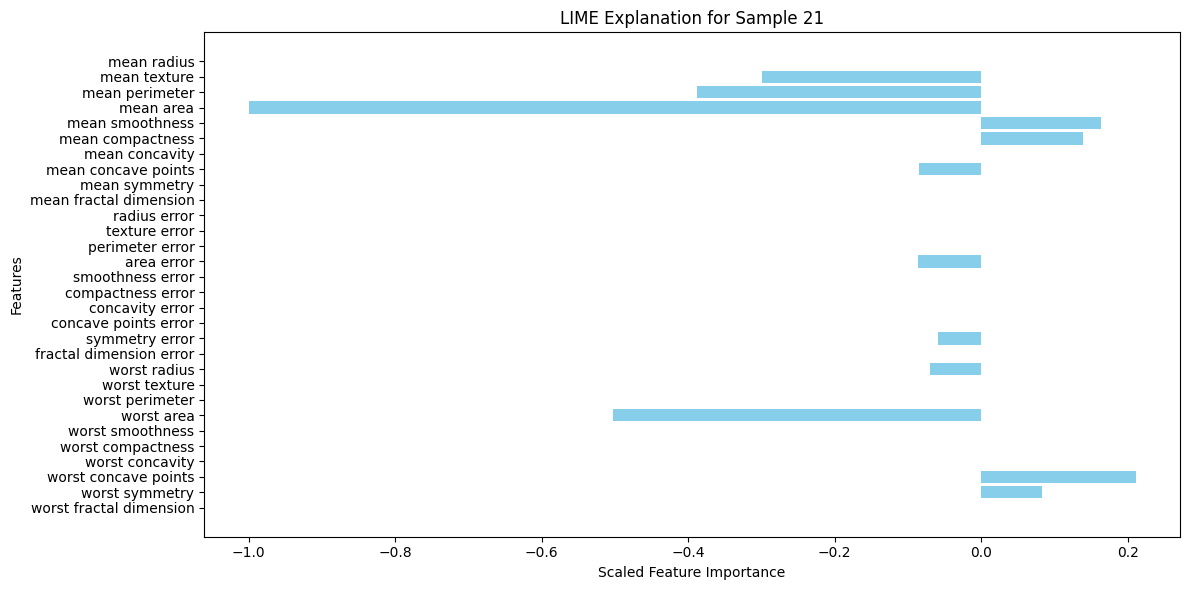

Sample 21 - Time: 0.0491s, Parsimony: 7, Correctness: 0.2052


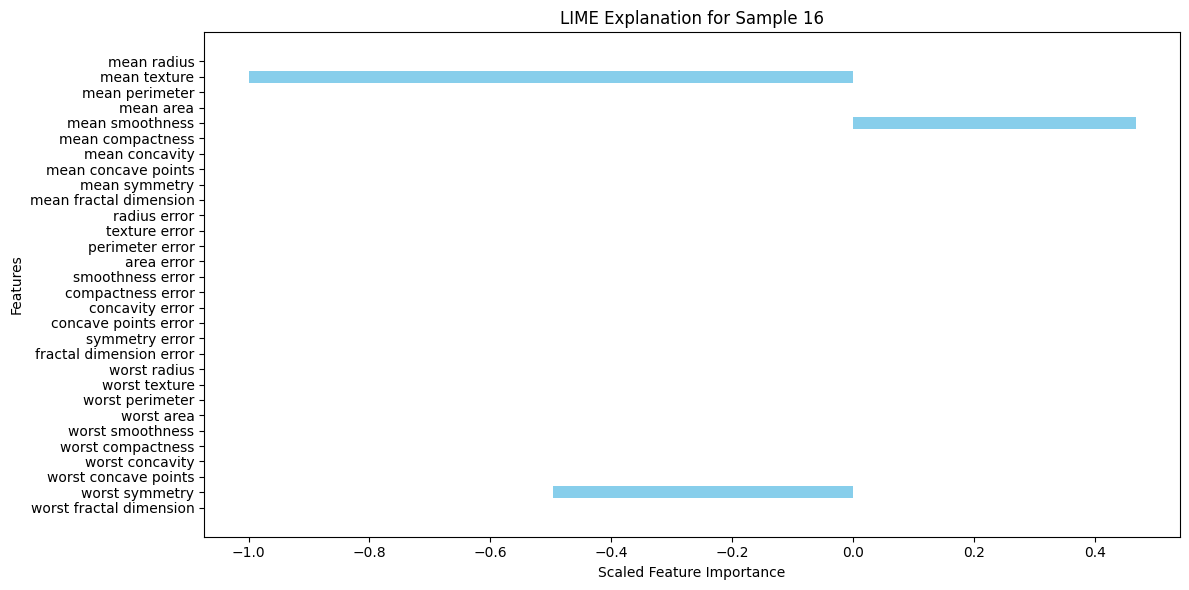

Sample 16 - Time: 0.0412s, Parsimony: 3, Correctness: 0.0358


In [132]:
print("\nExplanation Evaluation Metrics:")
metrics = evaluate_explanations(model, X_test, selected_indices, feature_names, tau=0.1)

### Perturbation Analysis: `perturbation_analysis`

This function evaluates LIME explanations by analyzing the model's performance under feature perturbations and plots the perturbation curve.

#### **Purpose**:
- Measures how the model's accuracy changes as the most important features (identified by LIME) are sequentially perturbed.
- Quantifies explanation reliability using the **Area Under the Perturbation Curve (AUPC)**.

#### **Inputs**:
- **`model`**: Trained PyTorch model.
- **`X_test`**: Test features.
- **`y_test`**: True test labels.
- **`lime`**: LIME object for generating explanations.
- **`feature_names`**: List of feature names for interpretation.
- **`max_features_to_perturb`**: Maximum number of features to perturb. *(Default: 10)*

#### **Outputs**:
- **`accuracy_per_perturbation`**: List of model accuracies as features are progressively perturbed.
- **`au_pc`**: Area Under the Perturbation Curve, where lower values indicate more impactful explanations.

#### **Process**:
1. **Feature Perturbation**:
   - Perturbs top-K most important features (Most Relevant First - MoRF) with their mean values.
2. **Model Evaluation**:
   - Computes accuracy on the perturbed dataset after each step.
3. **Perturbation Curve**:
   - Plots the number of perturbed features (x-axis) against model accuracy (y-axis).
4. **AUPC Calculation**:
   - Integrates the perturbation curve to quantify the overall impact of feature perturbations.

This function provides a quantitative and visual assessment of explanation quality.


In [133]:
def perturbation_analysis(
    model, X_test, y_test, lime, feature_names, max_features_to_perturb=10
):
    num_samples = X_test.shape[0]
    mean_features = torch.mean(X_test, dim=0)  # Mean feature values for perturbation
    accuracy_per_perturbation = []

    # Iterate over the number of features to perturb
    for k in range(1, max_features_to_perturb + 1):
        perturbed_X_test = X_test.clone()  # Clone original dataset

        # Perturb each instance
        for i in range(num_samples):
            input_sample = X_test[i].unsqueeze(0)

            # Ensure LIME receives a compatible output
            def single_output_model(input_tensor):
                with torch.no_grad():
                    outputs = model(input_tensor)
                    if outputs.size(1) > 1:  # Multiclass: select the score for the target class
                        return outputs[:, 1]  # Use the second class as the target for binary classification
                    else:
                        return outputs.squeeze()  # Single output case

            # Wrap the model for LIME
            lime_for_sample = Lime(single_output_model)

            # Generate explanation
            explanation = lime_for_sample.attribute(input_sample, n_samples=50)

            explanation = explanation.squeeze().detach().cpu().numpy()

            # Sort features by importance (MoRF order)
            feature_indices = np.argsort(-np.abs(explanation))[:k]

            # Replace top-k important features with their mean values
            perturbed_X_test[i, feature_indices] = mean_features[feature_indices]

        # Evaluate model accuracy on perturbed dataset
        with torch.no_grad():
            outputs = model(perturbed_X_test)

            if outputs.size(1) > 1:  # Multiclass: Use softmax and argmax for prediction
                predictions = torch.argmax(outputs, dim=1)
            else:  # Binary classifier: Use sigmoid and threshold at 0.5
                predictions = (torch.sigmoid(outputs) > 0.5).long().squeeze()

            correct_predictions = (predictions == y_test).sum().item()

        accuracy = correct_predictions / num_samples
        accuracy_per_perturbation.append(accuracy)

    # Plot Perturbation Curve
    plt.figure(figsize=(6, 4))
    plt.plot(
        range(1, max_features_to_perturb + 1),
        accuracy_per_perturbation,
        marker="o",
        color="blue",
        label="Perturbation Curve",
    )
    plt.xlabel("Number of Perturbed Features")
    plt.ylabel("Model Accuracy")
    plt.title("Perturbation Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Compute AUPC (Area Under the Perturbation Curve)
    au_pc = np.trapz(accuracy_per_perturbation, dx=1)
    print(f"Area Under the Perturbation Curve (AUPC): {au_pc:.4f}")

    return accuracy_per_perturbation, au_pc

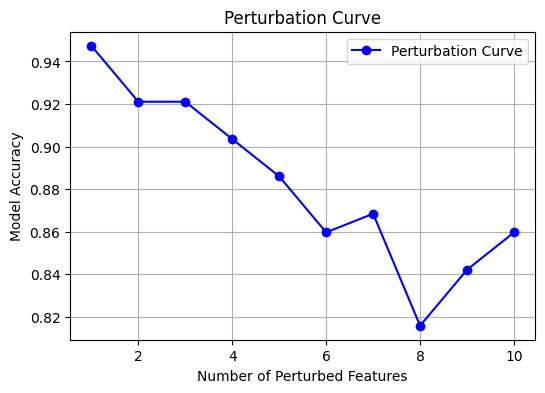

Area Under the Perturbation Curve (AUPC): 7.9211
Final AUPC: 7.9211
Average Accuracy Across Perturbations: 0.8825


In [134]:
accuracy_per_perturbation, au_pc = perturbation_analysis(
    model=model,
    X_test=X_test,
    y_test=y_test,
    lime=lime,
    feature_names=feature_names,
    max_features_to_perturb=10,
)
print(f"Final AUPC: {au_pc:.4f}")

avg_accuracy = np.mean(accuracy_per_perturbation)
print(f"Average Accuracy Across Perturbations: {avg_accuracy:.4f}")

In [135]:
def summarize_metrics(metrics):

    if not metrics:
        print("No metrics to summarize.")
        return {}

    avg_time = np.mean([m["Time (s)"] for m in metrics])
    avg_parsimony = np.mean([m["Parsimony"] for m in metrics])
    avg_correctness = np.mean([m["Correctness"] for m in metrics])

    summary = {
        "Average Time (s)": avg_time,
        "Average Parsimony": avg_parsimony,
        "Average Correctness": avg_correctness,
    }

    print("\nSummary of Metrics:")
    for key, value in summary.items():
        print(f"{key}: {value:.4f}")

    return summary

summary = summarize_metrics(metrics)


Summary of Metrics:
Average Time (s): 0.0414
Average Parsimony: 6.7500
Average Correctness: 0.2854
